## Objectives
### For this project, I used Kaggle's Titanic Dataset to:

- Understand what factors explain who lived and died on the ship
- Demonstrate how decision trees can reveal how those factors interact
- Show how we can convert those insights into features that are legible to other estimators

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in the data.
path = './datasets/titanic_train.csv'
titanic = pd.read_csv(path)
titanic.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [3]:
# create a test set and isolate that from training data; use random state for consistent replication
holdout = titanic.sample(frac=.1,random_state=4).copy()
titanic.drop(holdout.index,inplace=True)

### Understanding the data

In [4]:
# Survived, the target variable, is a boolean
# Age and embarkments, potentially useful features, contain null values
# Age is a float but it'd be easier to analyze as an int
# Pclass is an integer datatype but actually a categorical variables
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    802 non-null int64
Survived       802 non-null int64
Pclass         802 non-null int64
Name           802 non-null object
Sex            802 non-null object
Age            646 non-null float64
SibSp          802 non-null int64
Parch          802 non-null int64
Ticket         802 non-null object
Fare           802 non-null float64
Cabin          192 non-null object
Embarked       800 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 81.5+ KB


In [5]:
# change non-null age values to an integer
titanic['Age'] = titanic['Age'].round(0)

In [6]:
# 61.6% of passengers died
# this is our baseline: we'd expect to be right 61.6% of the time just guessing every passenger died
titanic.Survived.value_counts('mean')

0    0.605985
1    0.394015
Name: Survived, dtype: float64

#### what explains who lived and died?

In [7]:
def get_mean_count_survived(group_cols=None,new_cols=[]):
    '''
            Parameters:
                    group_cols (list): A list of columns to group by Survived
                    new_cols (list): A list of column names for the groupby dataframe

            Returns:
                    grouped_df (dataframe): A df with the input columns grouped by mean survival and a count of 
                                        passengers associated with a category (to ensure we don't extrapolate from a 
                                        small sample)
    '''
    grouped_df = titanic.groupby(group_cols)['Survived'].agg(['mean','count']).reset_index()
    if len(new_cols)>0:
        grouped_df.columns=new_cols
    return grouped_df

- age

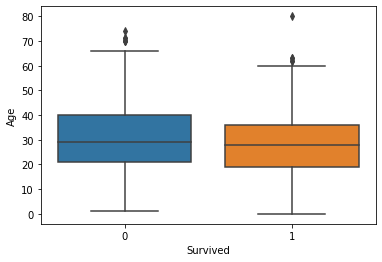

In [8]:
# age does not seem especially revealing
sns.boxplot('Survived','Age',data=titanic);

In [9]:
# but small children seem to be disproportionately likely to survive
# we can anticipate this if we know something about e.g. early 20th century chivalry, but a decision tree also
# picks out this relationship
age = get_mean_count_survived(group_cols=['Age'])
age[age.Age<10]

,Age,mean,count
0,0.0,1.000000,1
1,1.0,0.846154,13
2,2.0,0.142857,7
3,3.0,0.833333,6
4,4.0,0.777778,9
5,5.0,1.000000,3
6,6.0,0.500000,2
7,7.0,0.333333,3
8,8.0,0.500000,4
9,9.0,0.285714,7


- embarkments

In [10]:
# surival rates for embarkments do appear to be significantly different
emb = get_mean_count_survived(group_cols=['Embarked'])
emb

,Embarked,mean,count
0,C,0.560510,157
1,Q,0.376812,69
2,S,0.348432,574


- sex

In [11]:
# women are dramatically more likely to survive than men
sex = get_mean_count_survived(group_cols=['Sex'])
sex

,Sex,mean,count
0,female,0.743945,289
1,male,0.196881,513


- passenger class

In [12]:
# the higher the passenger class, the likelier the passenger is to survive
pclass = get_mean_count_survived(group_cols=['Pclass'])
pclass

,Pclass,mean,count
0,1,0.625616,203
1,2,0.490566,159
2,3,0.252273,440


- sex and passenger class

In [13]:
# looking at the combination of passenger class and sex shows how much likelier women in the same passenger class
# were to survive than men
# we could have real knowledge that leads us to this insight, or else stumble on it, or otherwise have it revealed
# to us by looking at a decision tree
sex_pclass = get_mean_count_survived(group_cols=['Pclass','Sex'],new_cols=['Pclass','Sex','sex_pclass_rate','count'])
sex_pclass

,Pclass,Sex,sex_pclass_rate,count
0,1,female,0.965517,87
1,1,male,0.370690,116
2,2,female,0.914286,70
3,2,male,0.157303,89
4,3,female,0.507576,132
5,3,male,0.142857,308


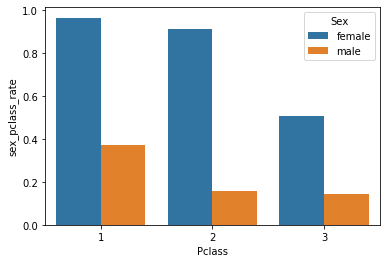

In [14]:
sns.barplot(x='Pclass',y='sex_pclass_rate',data=sex_pclass,hue='Sex');

### Preparing Data
#### nonlinear data

In [15]:
def make_X_y(df,feature_cols=None,dummy_cols=None,drop_first=False):
    '''
            Parameters:
                    df (dataframe): A dataframe containing all of our training or testing data
                    feature_cols (list): A list of features to use in predictive model
                    dummy_cols (list): A list of features to get dummy variables for
                    drop_first (bool): A parameter in pd.get_dummies() function

            Returns:
                    x (dataframe): A dataframe of subset, formatted train or test features
                    y (series): A pandas series of the target variable  
    '''
    x = df[feature_cols].copy()
    # use dummy variables because categorical variables have no numeric relationship
    x = pd.get_dummies(x,columns=dummy_cols,drop_first=drop_first)
    y = df.Survived
    return x, y

In [16]:
# Fill in the missing values for age. Median is immune to outliers; no obvious reason to impute with another value.
titanic.Age.fillna(titanic.Age.median(), inplace=True)
holdout.Age.fillna(titanic.Age.median(), inplace=True)

In [17]:
X_train_nonlinear, y_train_nonlinear = make_X_y(titanic,feature_cols=['Embarked','Pclass','Age','Sex'],
                                                dummy_cols=['Embarked','Pclass'])
# convert sex to numeric
X_train_nonlinear['Sex'] = X_train_nonlinear['Sex'].map(lambda x: 1 if x=='male' else 0)
X_train_nonlinear.head(1)

,Age,Sex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,0,1,0,0,1


In [18]:
X_test_nonlinear, y_test_nonlinear = make_X_y(holdout,feature_cols=['Embarked','Pclass','Age','Sex'],
                                                dummy_cols=['Embarked','Pclass'])
X_test_nonlinear['Sex'] = X_test_nonlinear['Sex'].map(lambda x: 1 if x=='male' else 0)

#### linear data

In [19]:
# add the surival rate for each gender in each passenger class to test and train
titanic = titanic.merge(sex_pclass.drop('count',axis=1),
                    on=['Sex','Pclass'])
holdout = holdout.merge(sex_pclass.drop('count',axis=1),
                    on=['Sex','Pclass'])

In [20]:
# we drop the first dummy variable in a linear model because that variable gets baked into the intercept 
# but it wouldn't make sense to drop a dummy variable for other estimators without an intercept
X_train_linear, y_train_linear = make_X_y(titanic,feature_cols=['Embarked','sex_pclass_rate','Age'],
                                                dummy_cols=['Embarked'],drop_first=True)
# convert age to childhood bool
X_train_linear['Age'] = X_train_linear['Age'].map(lambda x: 1 if x<9 else 0)
# sex and pclass are now represented as one feature, where the value is highly correlated with survival
X_train_linear.head(1)

,sex_pclass_rate,Age,Embarked_Q,Embarked_S
0,0.142857,0,0,1


In [21]:
X_test_linear, y_test_linear = make_X_y(holdout,feature_cols=['Embarked','sex_pclass_rate','Age'],
                                                dummy_cols=['Embarked'],drop_first=True)
X_test_linear['Age'] = X_test_linear['Age'].map(lambda x: 1 if x<9 else 0)

### Modeling

In [22]:
def instantiate_fit_score(estimator=None,X_train=None,y_train=None,X_test=None,y_test=None):
    '''
            Parameters:
                    estimator (sklearn object): A classifier with hyperparameters specified
                    X_train (dataframe): A dataframe with training data feature subset
                    y_train (series): A series with training data target variable
                    X_test (bool): A dataframe with testing data feature subset
                    y_test (series): A series with testing data target variable

            Returns:
                    clf (sklearn object): A model object fit on training data
    '''
    clf = estimator
    clf.fit(X_train, y_train)
    print('accuracy score: '+str(clf.score(X_test, y_test)))
    return clf

In [23]:
def make_conmat(clf=None,X_test=None,y_test=None):
    '''
            Parameters:
                    clf (sklearn object): A model object fit on training data
                    X_test (bool): A dataframe with testing data feature subset
                    y_test (series): A series with testing data target variable

            Returns:
                    confusion (dataframe): A confusion matrix of model performance on test data
    '''
    # get predictions for X test values 
    preds = clf.predict(X_test)
    # pass predictions and y test values into function
    conmat = confusion_matrix(y_test, preds)
    confusion = pd.DataFrame(conmat, index=['Actual: 0','Actual: 1'],
                             columns=['Pred: 0','Pred: 1'])
    return confusion

- simplified decision tree with nonlinear features

In [24]:
# parameters in treeclf to make tree for visualization and prevent overfitting
treeclf = instantiate_fit_score(estimator=DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,
                min_impurity_decrease=.001),X_train=X_train_nonlinear,y_train=y_train_nonlinear,
                X_test=X_test_nonlinear,y_test=y_test_nonlinear)
confusion_treeclf_nonlinear = make_conmat(clf=treeclf,X_test=X_test_nonlinear,y_test=y_test_nonlinear)
confusion_treeclf_nonlinear

accuracy score: 0.8876404494382022


,Pred: 0,Pred: 1
Actual: 0,61,2
Actual: 1,8,18


In [25]:
# Create a Graphviz file.
#from sklearn.tree import export_graphviz
# Create a Graphviz file.
#export_graphviz(treeclf, out_file='./tree_titanic.dot', feature_names=X_test_nonlinear.columns)
# use dot -Tpng tree_titanic.dot -o tree_titanic.png to convert to png

# this tree from an earlier implementation
# we see women in first and second class are overwhelmingly like to survive (149/157)
# women in third class who did not embrak from S were much more likely to survive than those who did
# male children under 10 were 50/50 to survive
# among other men, the best path to survival was being in first class and not being old

![](tree_titanic.png)

- logistic regression with nonlinear features

In [26]:
# the logistic regression underperforms the decision tree
logr_nonlinear = instantiate_fit_score(estimator=LogisticRegression(solver='liblinear'),X_train=X_train_nonlinear,
                             y_train=y_train_nonlinear,X_test=X_test_nonlinear,y_test=y_test_nonlinear)
confusion_logr_nonlinear = make_conmat(clf=logr_nonlinear,X_test=X_test_nonlinear,y_test=y_test_nonlinear)
confusion_logr_nonlinear

accuracy score: 0.8314606741573034


,Pred: 0,Pred: 1
Actual: 0,56,7
Actual: 1,8,18


- logistic regression with linear features

In [27]:
# but when we run the logistic regression again with more linear features, we cut down on false positives by 4 and
# mirror performance of decision tree
logr_linear = instantiate_fit_score(estimator=LogisticRegression(solver='liblinear'),X_train=X_train_linear,
                             y_train=y_train_linear,X_test=X_test_linear,y_test=y_test_linear)
confusion_treeclf_linear = make_conmat(clf=logr_linear,X_test=X_test_linear,y_test=y_test_linear)
confusion_treeclf_linear

accuracy score: 0.8764044943820225


,Pred: 0,Pred: 1
Actual: 0,60,3
Actual: 1,8,18
